In [1]:

!pip install -qU pymupdf4llm Pillow langchain langchain-openai langchain-text-splitters langchain_community langchain-pymupdf4llm langgraph gradio


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os

if not os.environ.get("OPENAI_API_KEY"):
    raise "OPENAI_API_KEY not set"

if not os.environ.get("LANGSMITH_API_KEY"):
    raise "LANGSMITH_API_KEY not set"
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "ai-final"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_TRACING_V2"] = "true"

PDF_FILE = "EPAM-Reports-Results-for-Fourth-Quarter-and-Full-Year-2024_4.pdf"

IMAGES_FOLDER = './storage/images'
TABLES_FOLDER = './storage/tables'

IMAGES_SUMMARY_MODEL = "gpt-4o-mini"
IMAGES_SUMMARY_PROMPT = "Describe the image in detail. For context, the image is part of a PDF document"

TABLES_SUMMARY_MODEL = "gpt-4o-mini"
TABLES_SUMMARY_PROMPT = "Describe the image of the table in detail. For context, the image is part of a PDF document."

LLM_MODEL = "gpt-4o-mini"

CHUNK_SIZE = 500
CHUNK_OVERLAP = 100

EMBEDDINGS_MODEL = "text-embedding-3-small"

AGENT_SYSTEM_PROMPT = """You are a helpful assistant that extracts information from PDF documents."""

os.makedirs(IMAGES_FOLDER, exist_ok=True)
os.makedirs(TABLES_FOLDER, exist_ok=True)


In [3]:
import fitz
import io
from PIL import Image
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.documents import Document
import pymupdf4llm
import base64
from IPython.display import Markdown
from langchain.chat_models import init_chat_model
import IPython.display
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore


In [4]:
doc: fitz.Document = fitz.open(PDF_FILE)

In [5]:
def summarize_images(images: list[str], prompt_template: str, model) -> list[str]:
    messages = [
        (
            "user",
            [
                {"type": "text", "text": prompt_template},
                {
                    "type": "image_url",
                    "image_url": {"url": "data:image/png;base64,{image}"},
                },
            ],
        )
    ]

    prompt = ChatPromptTemplate.from_messages(messages)

    chain = prompt | ChatOpenAI(model=model) | StrOutputParser()
    return chain.batch(images)

In [6]:

def extract_images(doc: fitz.Document, model: str, prompt: str, summarize: bool = True) -> list[Document]:
    documents: list[Document] = []
    images: list[str] = []
    for idx, page in enumerate(doc):
        for img in page.get_images(full=True):
            xref = img[0]
            base_image = doc.extract_image(xref)["image"]
            pil_image = Image.open(io.BytesIO(base_image))
            file = f"{IMAGES_FOLDER}/{idx}_{img[7]}.png"
            pil_image.save(file, "PNG")
            documents.append(
                Document(page_content="",
                         metadata=dict(doc.metadata, pdf=doc._name, page=page.number, file=file, type="image")))
            if summarize:
                images.append(base64.encodebytes(base_image).decode("ascii"))
    if summarize:
        summarized_images = summarize_images(images,
                                             prompt,
                                             model)
        for doc, summary in zip(documents, summarized_images):
            doc.page_content = summary
    return documents



In [7]:

def extract_tables(doc: fitz.Document, model: str, prompt: str, summarize: bool = True) -> list[Document]:
    documents: list[Document] = []
    images: list[str] = []
    for idx, page in enumerate(doc):
        tabs = page.find_tables()  # detect the tables
        for i, tab in enumerate(tabs):  # iterate over all tables
            pix = page.get_pixmap(clip=tab.bbox)
            file = f"{TABLES_FOLDER}/{idx}_{i}.png"
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            img.save(file, "PNG")
            buffered = io.BytesIO()
            img.save(buffered, format="PNG")
            documents.append(
                Document(page_content="",
                         metadata=dict(doc.metadata, pdf=doc._name, page=page.number, file=file, type="table")))
            if summarize:
                images.append(base64.encodebytes(buffered.getvalue()).decode("ascii"))
    if summarize:
        summarized_images = summarize_images(images, prompt, model)
        for doc, summary in zip(documents, summarized_images):
            doc.page_content = summary

    return documents


In [8]:

def extract_text(doc: fitz.Document) -> list[Document]:
    pages = pymupdf4llm.to_markdown(doc=doc, ignore_images=True, table_strategy=None, page_chunks=True)
    return [Document(page_content=page['text'], metadata=dict(page['metadata'], type='text')) for page in pages if
            len(page['text']) > 0]


In [9]:
llm = init_chat_model(LLM_MODEL, model_provider="openai")

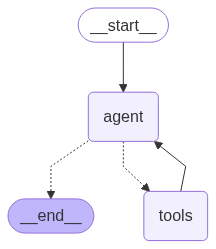

In [10]:

@tool(response_format="content_and_artifact")
def retrieve_tables(query: str):
    """Retrieve tables related to a query"""
    retrieved_docs = vector_store.similarity_search(query, k=10, filter={"type": "table"})
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


@tool(response_format="content_and_artifact")
def retrieve_images(query: str):
    """Retrieve images related to a query"""
    retrieved_docs = vector_store.similarity_search(query, k=10, filter={"type": "table"})
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=4)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


def create_agent():
    return create_react_agent(llm, [retrieve, retrieve_images, retrieve_images], prompt=AGENT_SYSTEM_PROMPT,
                              checkpointer=MemorySaver())


agent_executor = create_agent()
display(IPython.display.Image(agent_executor.get_graph().draw_mermaid_png()))


In [11]:
def create_retriever(embeddings_model: str, chunk_size: int, chunk_overlap: int):
    embeddings = OpenAIEmbeddings(model=embeddings_model)
    # vector_store = Chroma(
    #     collection_name="aifinals_collection",
    #     embedding_function=embeddings,
    #     persist_directory="./storage/db",  # Where to save data locally, remove if not necessary
    # )

    store = InMemoryStore()
    return ParentDocumentRetriever(
        vectorstore=InMemoryVectorStore(embeddings),
        docstore=store,
        child_splitter=RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap),
    )


In [12]:
retriever = create_retriever(EMBEDDINGS_MODEL, CHUNK_SIZE, CHUNK_OVERLAP)

In [18]:
import gradio as gr


def recreate_db_lst(embeddings_model: str, chunk_size: int, chunk_overlap: int):
    global retriever
    retriever = create_retriever(embeddings_model, chunk_size, chunk_overlap)
    return "Retriever recreated"


def show_documents(type):
    documents = retriever.vectorstore.similarity_search("", k=100, filter=lambda x: x.metadata["type"] == type)
    return documents_to_markdown(documents)


def extract_images_lst(summary_model: str, summary_prompt: str):
    retriever.add_documents(extract_images(doc, summary_model, summary_prompt))
    return show_documents("image")


def extract_tables_lst(summary_model: str, summary_prompt: str):
    retriever.add_documents(extract_tables(doc, summary_model, summary_prompt))
    return show_documents("table")


def documents_to_markdown(documents: list[Document]) -> str:
    sorted_documents = sorted(documents, key=lambda x: x.metadata['page'], reverse=False)
    if len(sorted_documents) == 0:
        return "No documents found"

    res = ""

    for idx, document in enumerate(sorted_documents):
        res += f"# {idx + 1}/{len(sorted_documents)} {document.id}\n"
        for key, value in document.metadata.items():
            res += f"**{key}:** {value}\n"
        res += "\n"
        if document.metadata['type'] == 'table' or document.metadata['type'] == 'image':
            with open(document.metadata["file"], "rb") as image_file:
                encoded_string = base64.b64encode(image_file.read()).decode('ascii')
            img = "![](data:image/png;base64," + encoded_string + ")"
            res += img + "\n"
        res += document.page_content + "\n***\n"
    return res


def reimport_db_lst(embeddings_model: str, chunk_size, chunk_overlap, images_summary_model, images_summary_prompt,
                    tables_summary_model, tables_summary_prompt):
    global retriever
    recreate_db_lst(embeddings_model, chunk_size, chunk_overlap)
    retriever.add_documents(extract_text(doc))
    retriever.add_documents(extract_images(doc, images_summary_model, images_summary_prompt))
    retriever.add_documents(extract_tables(doc, tables_summary_model, tables_summary_prompt))
    return "Document is reimported"


def query_lst(query: str):
    global retriever
    return documents_to_markdown(retriever.invoke(query))


def handle_click(button: gr.Button, all_buttons: list[gr.Button], **kwargs) -> None:
    button.click(fn=lambda: tuple([gr.update(interactive=False) for b in all_buttons]), inputs=None,
                 outputs=all_buttons) \
        .then(**kwargs) \
        .then(fn=lambda: tuple([gr.update(interactive=True) for b in all_buttons]), inputs=None,
              outputs=all_buttons)


with (gr.Blocks() as demo):
    with gr.Row():
        with gr.Column():
            with gr.Row():
                query = gr.Textbox(label="Query")
            with gr.Row():
                query_btn = gr.Button("Run query")
            with gr.Row():
                embeddings_model = gr.Textbox(label="Embeddings model", value=EMBEDDINGS_MODEL)
            with gr.Row():
                recreate_db_btn = gr.Button("Recreate Vector Storage")
                reimport_db_btn = gr.Button("Reimport full document")
                show_text_btn = gr.Button("Show text")

            with gr.Row():
                chunk_size = gr.Number(label="Chunk size", value=CHUNK_SIZE)
                chunk_overlap = gr.Number(label="Chunk overlap", value=CHUNK_OVERLAP)
            with gr.Row():
                images_summary_model = gr.Textbox(label="Images summary model", value=IMAGES_SUMMARY_MODEL)
                images_summary_prompt = gr.Textbox(label="Images summary prompt", value=IMAGES_SUMMARY_PROMPT)
            with gr.Row():
                extract_images_btn = gr.Button("Import images")
                show_images_btn = gr.Button("Show images")
            with gr.Row():
                tables_summary_model = gr.Textbox(label="Tables summary model", value=TABLES_SUMMARY_MODEL)
                tables_summary_prompt = gr.Textbox(label="Tables summary prompt", value=TABLES_SUMMARY_PROMPT)
            with gr.Row():
                extract_tables_btn = gr.Button("Tables")
                show_tables_btn = gr.Button("Show tables")

        with gr.Column(min_width=300):
            out = gr.Markdown()
    buttons = [extract_images_btn, show_images_btn, recreate_db_btn, extract_tables_btn, show_tables_btn,
               reimport_db_btn, show_text_btn, query_btn]

    handle_click(query_btn, buttons, fn=query_lst, inputs=query, outputs=out)

    handle_click(recreate_db_btn, buttons, fn=recreate_db_lst, inputs=[embeddings_model, chunk_size, chunk_overlap],
                 outputs=out)

    handle_click(extract_images_btn, buttons, fn=extract_images_lst,
                 inputs=[images_summary_model, images_summary_prompt], outputs=out)
    handle_click(show_images_btn, buttons, fn=lambda: show_documents("image"), outputs=out)

    handle_click(extract_tables_btn, buttons, fn=extract_tables_lst,
                 inputs=[tables_summary_model, tables_summary_prompt], outputs=out)
    handle_click(show_tables_btn, buttons, fn=lambda: show_documents("table"), outputs=out)

    handle_click(show_text_btn, buttons, fn=lambda: show_documents("text"), outputs=out)
    handle_click(reimport_db_btn, buttons, fn=reimport_db_lst,
                 inputs=[embeddings_model, chunk_size, chunk_overlap, images_summary_model, images_summary_prompt,
                         tables_summary_model, tables_summary_prompt],
                 outputs=out)

    # llm_model = gr.Textbox(label="LLM model", value=LLM_MODEL)

demo.launch()

* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.
